
# Assignment 8: Clustering Analysis (K-Means, Hierarchical, DBSCAN)


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set(style="whitegrid")


## Load Dataset (Excel)

In [2]:
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name="data") # Assuming data is in 'data' sheet
print("Shape:", df.shape)
df.head()

Shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
df_num = df.select_dtypes(include=np.number).copy()
print("Numeric shape:", df_num.shape)
df_num.head()


Numeric shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
df_num = df_num.fillna(df_num.median(numeric_only=True))
df_num.isnull().sum().head()


,0
ID#,0
Balance,0
Qual_miles,0
cc1_miles,0
cc2_miles,0


In [5]:
df_capped = df_num.copy()

for col in df_capped.columns:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_capped[col] = df_capped[col].clip(lower, upper)

df_capped.describe().T.head()


,count,mean,std,min,25%,50%,75%,max
ID#,3999.0,2014.819455,1160.764358,1.0,1010.5,2016.0,3020.5,4021.00
Balance,3999.0,63768.635784,58673.700736,0.0,18527.5,43097.0,92404.0,203218.75
Qual_miles,3999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
cc1_miles,3999.0,2.059515,1.376919,1.0,1.0,1.0,3.0,5.00
cc2_miles,3999.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00


##Standardization

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_capped)

X_scaled.shape


(3999, 12)

# EDA

In [7]:
df_capped.describe().T


,count,mean,std,min,25%,50%,75%,max
ID#,3999.0,2014.819455,1160.764358,1.0,1010.5,2016.0,3020.5,4021.00
Balance,3999.0,63768.635784,58673.700736,0.0,18527.5,43097.0,92404.0,203218.75
Qual_miles,3999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
cc1_miles,3999.0,2.059515,1.376919,1.0,1.0,1.0,3.0,5.00
cc2_miles,3999.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00
cc3_miles,3999.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00
Bonus_miles,3999.0,15410.730683,18074.733482,0.0,1250.0,7171.0,23800.5,57626.25
Bonus_trans,3999.0,11.470618,9.115104,0.0,3.0,12.0,17.0,38.00
Flight_miles_12mo,3999.0,178.055639,294.678028,0.0,0.0,0.0,311.0,777.50
Flight_trans_12,3999.0,0.591523,0.944826,0.0,0.0,0.0,1.0,2.50


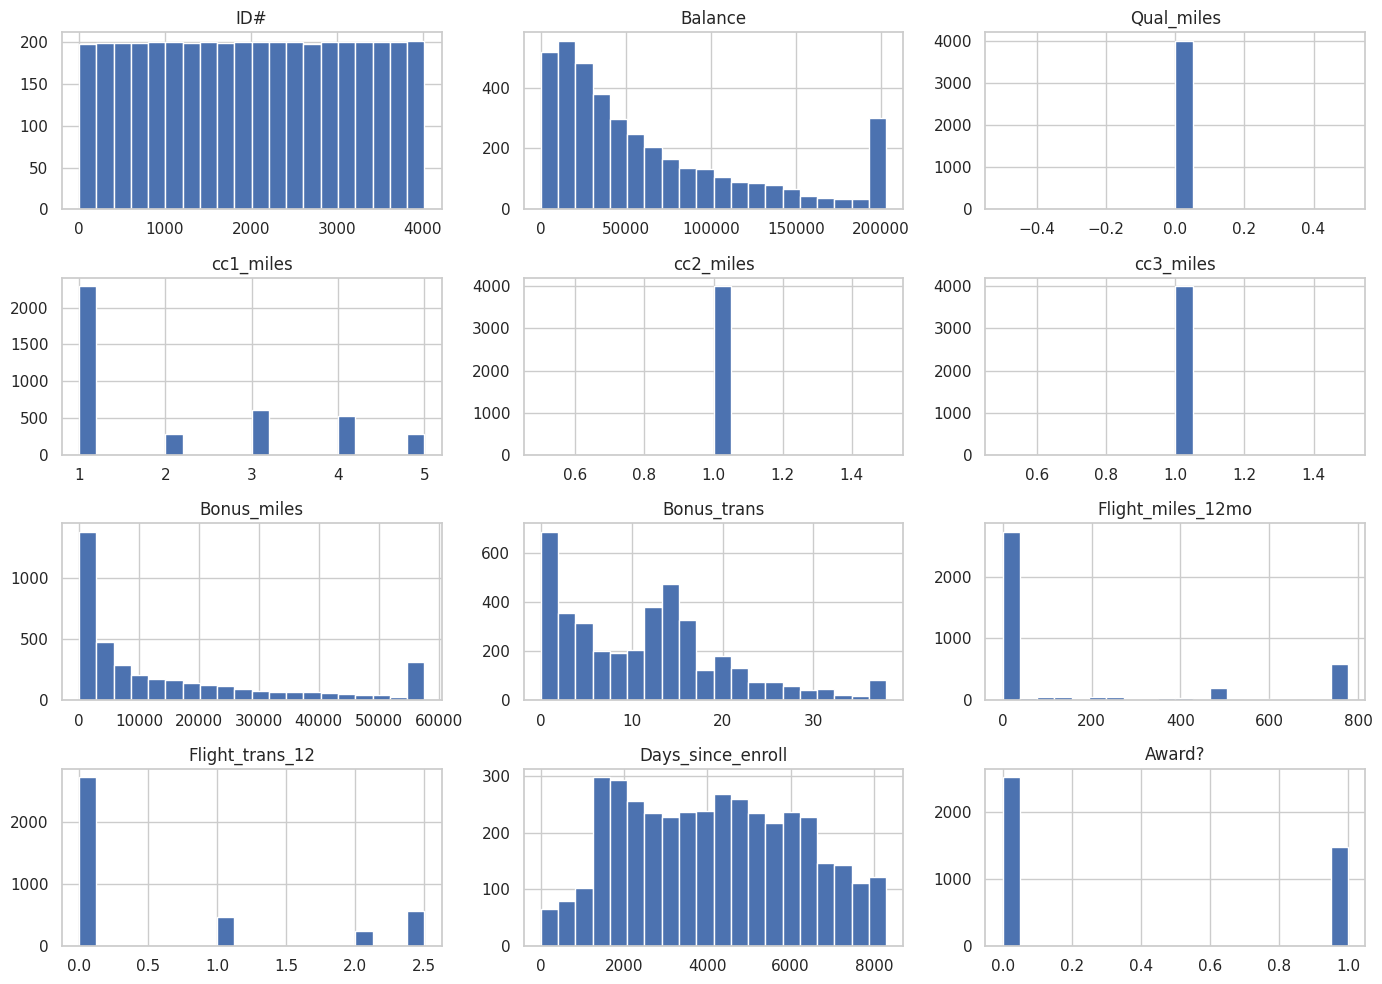

In [8]:
df_capped.hist(figsize=(14,10), bins=20)
plt.tight_layout()
plt.show()


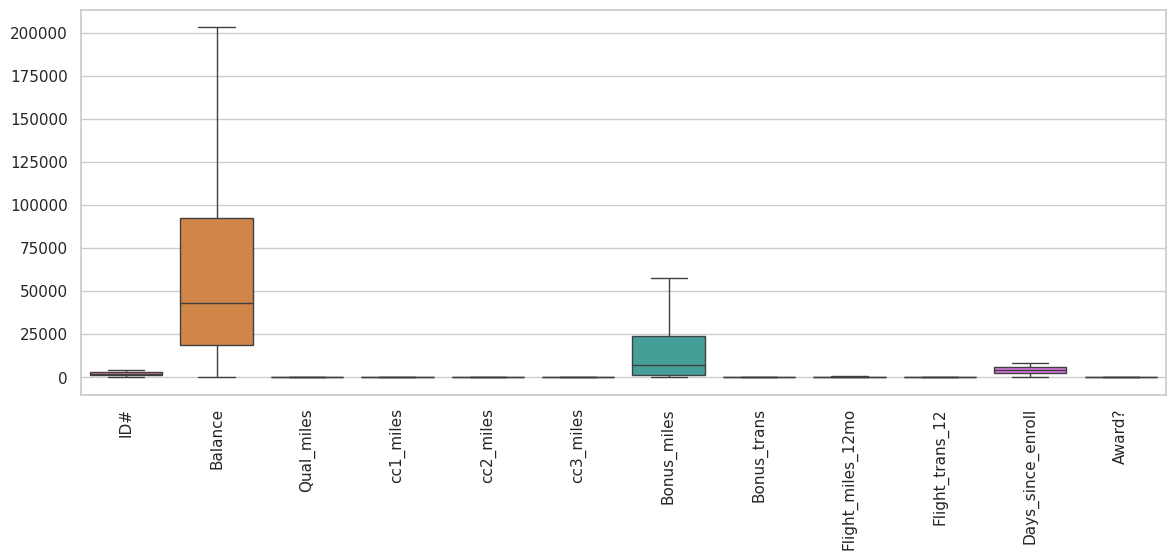

In [9]:
plt.figure(figsize=(14,5))
sns.boxplot(data=df_capped)
plt.xticks(rotation=90)
plt.show()


Explained variance ratio: [0.40502879 0.20189056]


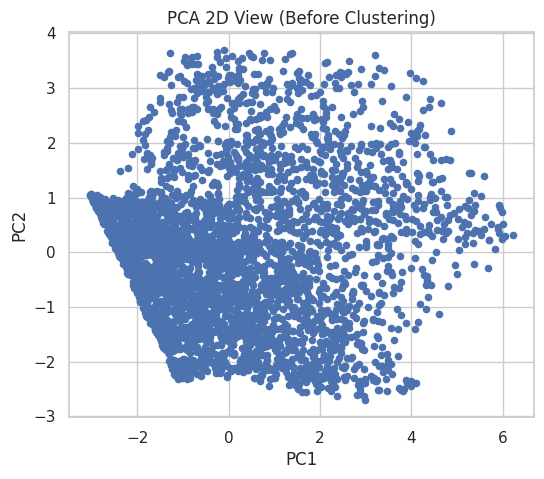

In [10]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=20)
plt.title("PCA 2D View (Before Clustering)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# 2) K-Means Clustering

## Cell 13 — Elbow Method (Inertia vs K)

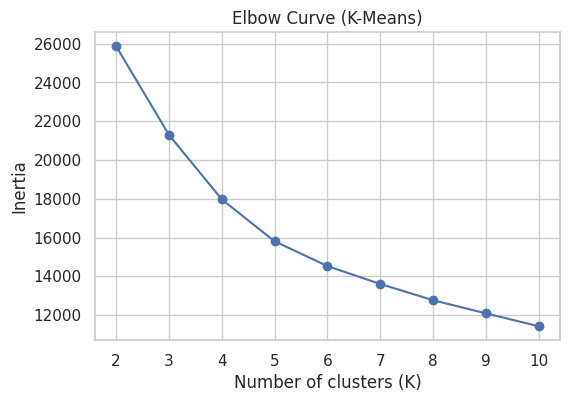

In [11]:
inertias = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(k_values), inertias, marker="o")
plt.title("Elbow Curve (K-Means)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.show()


## Cell 14 — Silhouette Score vs K

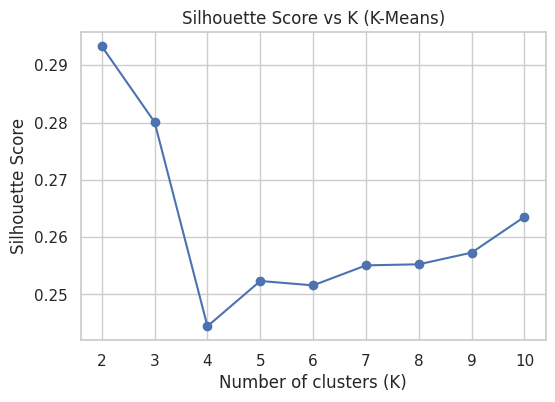

Best K by silhouette (2 to 10): 2


In [12]:
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(list(k_values), sil_scores, marker="o")
plt.title("Silhouette Score vs K (K-Means)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

best_k = list(k_values)[int(np.argmax(sil_scores))]
print("Best K by silhouette (2 to 10):", best_k)


## Cell 15 — Fit Final K-Means Model + Visualize in PCA

K-Means Silhouette Score: 0.2933


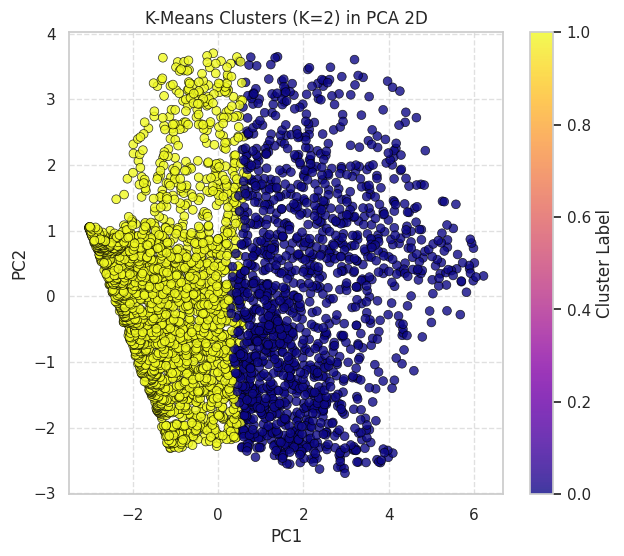

In [13]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
print("K-Means Silhouette Score:", round(kmeans_sil, 4))

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, s=40, cmap='plasma', alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title(f"K-Means Clusters (K={best_k}) in PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Cell 16 — K-Means Cluster Profiling

In [14]:
kmeans_profile = df_capped.copy()
kmeans_profile["Cluster"] = kmeans_labels

kmeans_profile.groupby("Cluster").mean().round(2)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
Cluster,,,,,,,,,,,,
0,1454.33,107529.44,0.0,3.35,1.0,1.0,33089.92,18.89,332.86,1.08,5140.63,0.67
1,2332.62,38955.99,0.0,1.33,1.0,1.0,5386.52,7.26,90.28,0.32,3539.04,0.20


# 3) Hierarchical Clustering

## Cell 17 — Dendrogram (Sample for readability)

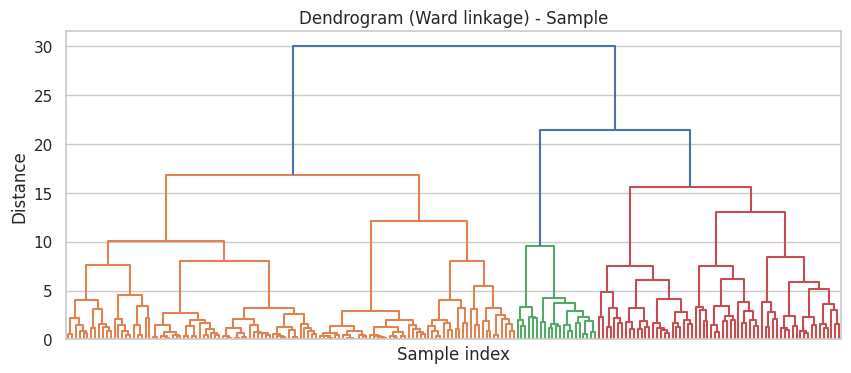

In [15]:
sample_size = min(200, X_scaled.shape[0])
sample_idx = np.random.RandomState(42).choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

Z_ward = linkage(X_sample, method="ward")

plt.figure(figsize=(10,4))
dendrogram(Z_ward, no_labels=True)
plt.title("Dendrogram (Ward linkage) - Sample")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


## Cell 18 — Try Different Linkage Methods and Visualize

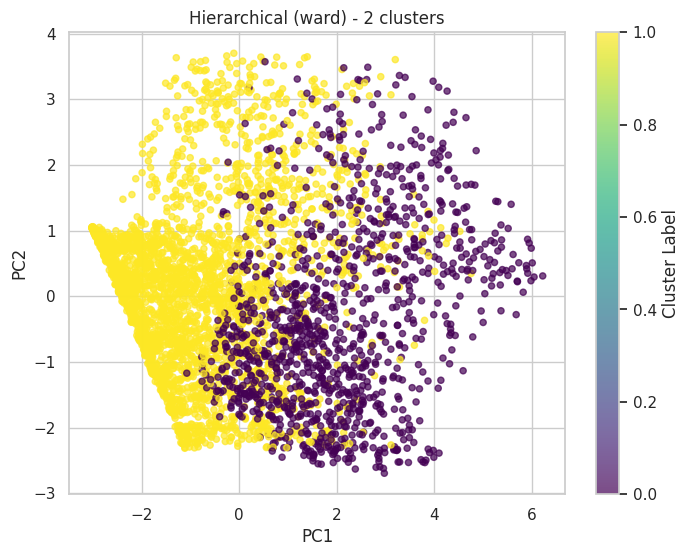

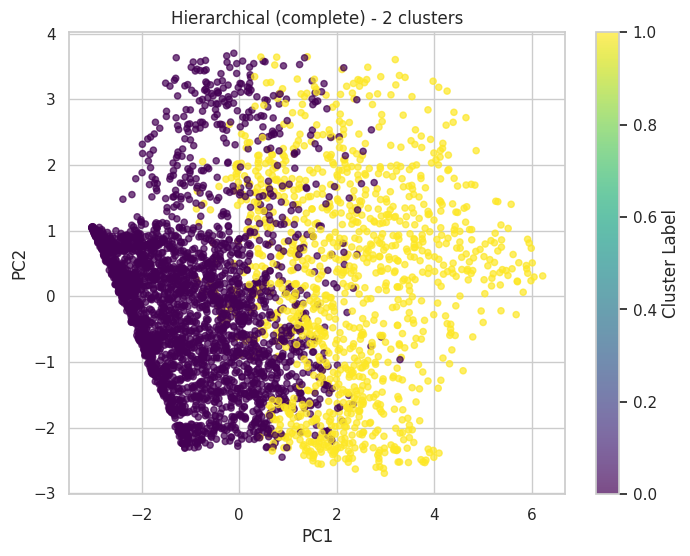

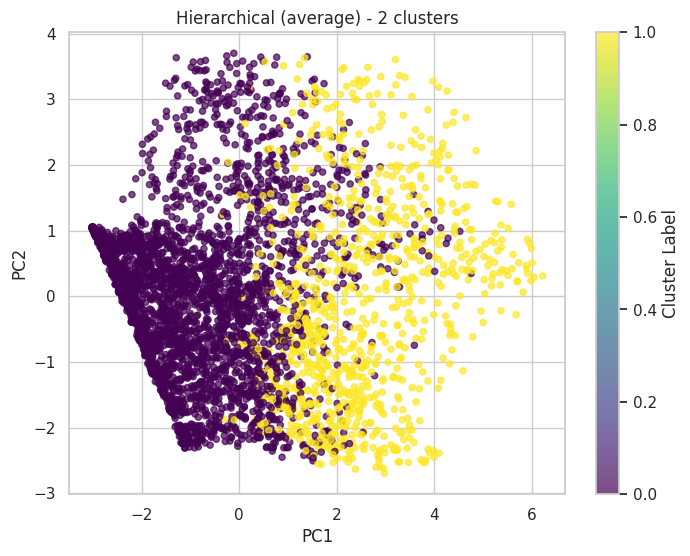

In [16]:
linkage_methods = ["ward", "complete", "average"]
n_clusters_h = best_k

hier_results = {}

for method in linkage_methods:
    Z = linkage(X_scaled, method=method)
    labels = fcluster(Z, t=n_clusters_h, criterion="maxclust") - 1
    hier_results[method] = labels

    plt.figure(figsize=(8,6))

    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20, cmap='viridis', alpha=0.7)
    plt.title(f"Hierarchical ({method}) - {n_clusters_h} clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label='Cluster Label')
    plt.show()

## Cell 19 — Hierarchical Cluster Profiling (Ward example)

In [17]:
hier_profile = df_capped.copy()
hier_profile["Cluster"] = hier_results["ward"]

hier_profile.groupby("Cluster").mean().round(2)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
Cluster,,,,,,,,,,,,
0,1537.12,102744.49,0.0,3.87,1.0,1.0,38130.54,19.25,242.09,0.79,4971.22,0.50
1,2206.70,48112.72,0.0,1.33,1.0,1.0,6284.58,8.35,152.33,0.51,3776.06,0.32


# 4) DBSCAN Clustering

## Cell 20 — k-distance plot (helps choose eps)

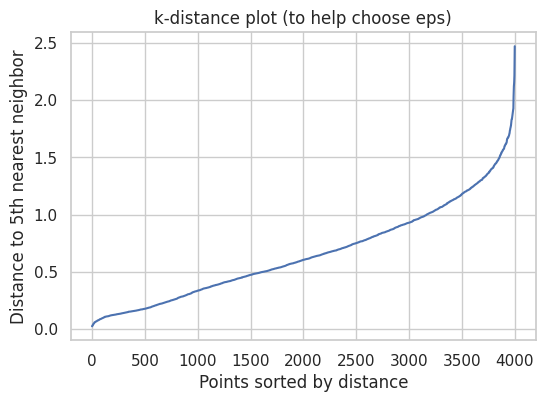

In [18]:
from sklearn.neighbors import NearestNeighbors

min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.title("k-distance plot (to help choose eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}th nearest neighbor")
plt.show()


## Cell 21 — DBSCAN Parameter Experiments + Silhouette

DBSCAN with eps=2.0, min_samples=5:
  - Clusters found: 2
  - Noise points: 2


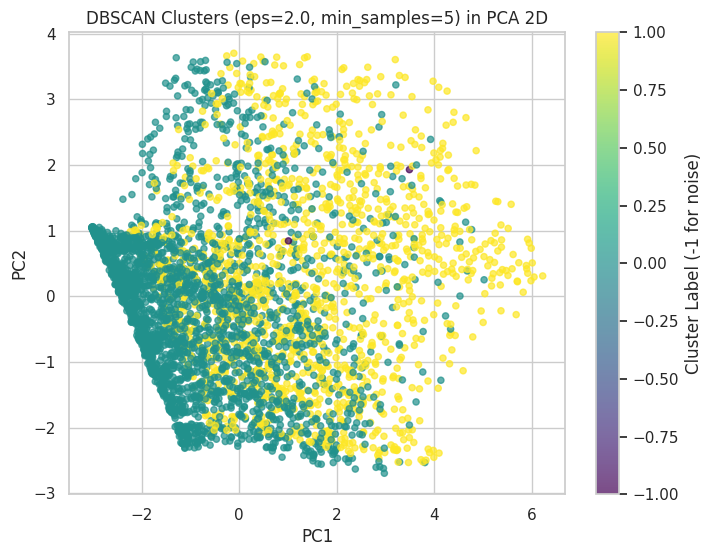

Silhouette Score (excluding noise): 0.2173


In [19]:
eps = 2.0
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_points = np.sum(labels == -1)

print(f"DBSCAN with eps={eps}, min_samples={min_samples}:")
print(f"  - Clusters found: {n_clusters}")
print(f"  - Noise points: {noise_points}")

plt.figure(figsize=(8,6))

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20, cmap='viridis', alpha=0.7)
plt.title(f"DBSCAN Clusters (eps={eps}, min_samples={min_samples}) in PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label (-1 for noise)')
plt.show()

if n_clusters >= 2 and noise_points < len(labels):
    mask = labels != -1
    score = silhouette_score(X_scaled[mask], labels[mask])
    print(f"Silhouette Score (excluding noise): {round(score, 4)}")
else:
    print("Silhouette score not calculated (less than 2 clusters or all noise).")
